In [1]:
%matplotlib inline
import pickle
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

import time
from datetime import timedelta
import cv2
import matplotlib.image as mpimg
import matplotlib.gridspec as gridspec

# Importing the datasets 

In [2]:
training_file = "train.p"
testing_file = "test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

# X_train, X_validation, y_train, y_validation = train_test_split(
#     X_train,
#     y_train,
    
#     test_size=0.2,
#     random_state=832289)



# Augmenting the dataset

In [3]:
def transform_image(img,ang_range,shear_range,trans_range):
    '''
    This function transforms images to generate new images.
    The function takes in following arguments,
    1- Image
    2- ang_range: Range of angles for rotation
    3- shear_range: Range of values to apply affine transform to
    4- trans_range: Range of values to apply translations over. 
    
    A Random uniform distribution is used to generate different parameters for transformation
    
    '''
    # Rotation

    ang_rot = np.random.uniform(ang_range)-ang_range/2
    rows,cols,ch = img.shape    
    Rot_M = cv2.getRotationMatrix2D((cols/2,rows/2),ang_rot,1)

    # Translation
    tr_x = trans_range*np.random.uniform()-trans_range/2
    tr_y = trans_range*np.random.uniform()-trans_range/2
    Trans_M = np.float32([[1,0,tr_x],[0,1,tr_y]])

    # Shear
    pts1 = np.float32([[5,5],[20,5],[5,20]])

    pt1 = 5+shear_range*np.random.uniform()-shear_range/2
    pt2 = 20+shear_range*np.random.uniform()-shear_range/2

    pts2 = np.float32([[pt1,5],[pt2,pt1],[5,pt2]])

    shear_M = cv2.getAffineTransform(pts1,pts2)
        
    img = cv2.warpAffine(img,Rot_M,(cols,rows))
    img = cv2.warpAffine(img,Trans_M,(cols,rows))
    img = cv2.warpAffine(img,shear_M,(cols,rows))
    
    return img

In [4]:
# 3 million images tto much ? 

start_time = time.time()

jittered_images = []
jittered_labels = []

for i in range(len(X_train)):
    for j in range(1):
        img = transform_image(X_train[i],20,10,5)
        jittered_images.append(img)
        jittered_labels.append(y_train[i])
        


end_time = time.time()
compute_time = end_time - start_time

print("compute time: " , str(timedelta(seconds = int(round(compute_time)))))


compute time:  0:00:03


## Dataset facts 

In [5]:
n_train = len(jittered_labels)
n_validation = len(y_train)
n_test = len(y_test)
image_shape  = np.shape(X_train[1])
n_classes = len(np.unique(y_train))

img_size_flat = image_shape[0] * image_shape[1]

print("Number of training examples =", n_train)
print("Number of training examples =", n_validation)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

print("Image Size Flat =", img_size_flat)

Number of training examples = 39209
Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43
Image Size Flat = 1024


# One-hot encoding the labels

In [6]:
# y_train_encoded = np.eye(43)[y_tiny]
# y_test_encoded = np.eye(43)[y_tiny]
y_train_encoded = np.eye(43)[jittered_labels]
y_validation_encoded = np.eye(43)[y_train]
y_test_encoded = np.eye(43)[y_test]

In [7]:
y_train_encoded[0]

array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.])

# Pre-processing the images


In [8]:
def pre_process_image(image):
    
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = cv2.resize(image, (32,32),interpolation = cv2.INTER_CUBIC)
    
#     Min-Max scaling for greyscale image data
    Xmin = 0
    Xmax = 255
    a = 0.1
    b = 0.9
    
    image = a + ((image - Xmin) * (b-a)) / (Xmax-Xmin)
#     image = image - 83
    return image

In [9]:
import math 

start_time = time.time()

batch_size = 31367
batch_count = int(math.ceil(len(jittered_images)/batch_size))
# batch_count = 2

image_GS_train = []

for batch_i in range(batch_count):
            # Get a batch of jittered images
            batch_start = batch_i*batch_size
            batch_features = jittered_images[batch_start:batch_start + batch_size]
            batch_labels = jittered_labels[batch_start:batch_start + batch_size]
            
            batch_GS_train = np.array([pre_process_image(batch_features[i]) for i in range(len(batch_features))], dtype = np.float32)
            
            for img in batch_GS_train:
                image_GS_train.append(img)
#                 np.append(image_GS_train, img)


image_GS_train = np.asarray(image_GS_train)    
end_time = time.time()
compute_time = end_time - start_time
print("compute time: " , str(timedelta(seconds = int(round(compute_time)))))

            

compute time:  0:00:01


In [10]:
len(image_GS_train)
image_GS_train[0]

array([[ 0.27568626,  0.31647059,  0.36666667, ...,  0.39490196,
         0.38235295,  0.3509804 ],
       [ 0.41999999,  0.43254903,  0.47019607, ...,  0.37607843,
         0.36352941,  0.34470588],
       [ 0.44509804,  0.44196078,  0.49843138, ...,  0.35725489,
         0.34470588,  0.33215687],
       ..., 
       [ 0.25058824,  0.41999999,  0.49215686, ...,  0.1       ,
         0.1       ,  0.1       ],
       [ 0.18470588,  0.38235295,  0.47647059, ...,  0.1       ,
         0.1       ,  0.1       ],
       [ 0.13137256,  0.31960785,  0.42313725, ...,  0.1       ,
         0.1       ,  0.1       ]], dtype=float32)

In [11]:
# image_GS_train = np.array([pre_process_image(X_tiny[i]) for i in range(len(X_tiny))], dtype = np.float32)
# image_GS_test = np.array([pre_process_image(X_tiny[i]) for i in range(len(X_tiny))], dtype = np.float32)

image_GS_train = np.array([pre_process_image(jittered_images[i]) for i in range(len(jittered_images))], dtype = np.float32)

image_GS_validation = np.array([pre_process_image(X_train[i]) for i in range(len(X_train))], dtype = np.float32)
image_GS_test = np.array([pre_process_image(X_test[i]) for i in range(len(X_test))], dtype = np.float32)

In [12]:
image_flat_train = image_GS_train.reshape((-1,img_size_flat))
image_flat_validation = image_GS_validation.reshape((-1,img_size_flat))
image_flat_test  = image_GS_test.reshape((-1,img_size_flat))

In [13]:
def process_and_flatten(image_array):
    images_gray = np.array([pre_process_image(image_array[i]) for i in range(len(image_array))], dtype = np.float32)
    images_flat= images_gray.reshape((-1,img_size_flat))
#         Min-Max scaling for greyscale image data
    Xmin = 0
    Xmax = 255
    a = 0.1
    b = 0.9
    
    images_new = a + ((images_flat - Xmin) * (b-a)) / (Xmax-Xmin)
    return images_new

In [14]:
(image_flat_train[0]) 

array([ 0.27568626,  0.31647059,  0.36666667, ...,  0.1       ,
        0.1       ,  0.1       ], dtype=float32)

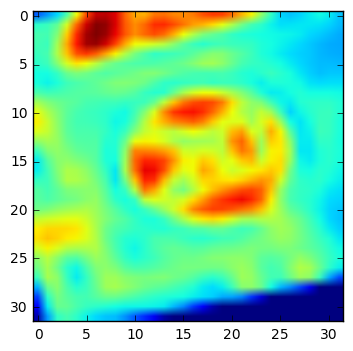

In [15]:
plt.imshow(image_GS_train[0])

# Batching

In [16]:
def random_batch():
    # Number of images in the training-set.
    num_images = len(image_flat_train)

    # Create a random index.
    idx = np.random.choice(num_images,
                           size=batch_size,
                           replace=False)

    # Use the random index to select random images and labels.
    features_batch = image_flat_train[idx, :]
    labels_batch = y_train_encoded[idx, :]

    return features_batch, labels_batch

# Configuring the Neural Network


In [17]:
# Convolutional Layer 1.
filter_size1 = 4         # Convolution filters are 5 x 5 pixels.
num_filters1 = 16         # There are 16 of these filters.

# Convolutional Layer 2.
filter_size2 = 4      # Convolution filters are 5 x 5 pixels.
num_filters2 = 36         # There are 36 of these filters.

# Fully-connected layer.
fc_size = 128 

# Setting up the TensorFlow model

## setting up the placeholder variables

# TensorFlow model

In [18]:
-

# TensorFlow Session


In [19]:

def optimize(n_iterations):
    accuracy_list = []
    loss_list = []
    iteration_list = []
    
    for iteration in range(n_iterations):
        features_batch, labels_true_batch = random_batch()
        feed_dict_batch = {x: features_batch, y: labels_true_batch}
        sess.run(optimizer, feed_dict = feed_dict_batch)
        
#         feed_dict_test = {x: image_flat_test,
#                   y: y_test_encoded,
#                   y_true_cls:y_test}
        
        
#         acc = sess.run(accuracy,feed_dict=feed_dict_test)

#         accuracy_list.append(acc)
#         loss = sess.run(cost,feed_dict=feed_dict_test)

#         loss_list.append(loss)
#         iteration_list.append(iteration)
#         print(iteration)
        
        
#     loss_plot = plt.subplot(211)
#     loss_plot.set_title('Loss & Accuracy')
#     loss_plot.plot(iteration_list, loss_list, 'g')
#     acc_plot = loss_plot.twinx()
#     acc_plot.plot(iteration_list, accuracy_list, 'b')
        
    
        

In [20]:
sess = tf.Session()


In [21]:
start_time = time.time()
sess.run(tf.initialize_all_variables())

iter = 10

optimize(iter)

end_time = time.time()
compute_time = end_time - start_time

print("compute time: " , str(timedelta(seconds = int(round(compute_time)))))

compute time:  0:00:01


## Getting the accuracy on the Test Set

In [22]:
feed_dict_test = {x: image_flat_test,
                  y: y_test_encoded,
                  y_true_cls:y_test}


# feed_dict_test = {x: image_flat_test,
#                   y: y_test_encoded,
#                   y_true_cls:y_test}

In [23]:

acc = sess.run(accuracy,feed_dict=feed_dict_test)
print(acc)
    

0.0525732


## writing out a log of model parameters and performance


In [24]:
log_file = "log.txt"
special_note = "normalization and changed filters to 4x4px. uses an augmented dataset (40x)"
with open(log_file, "a") as myfile:
    myfile.write("\n"+str(iter)+","+str(learning_rate)+
                 ","+str(batch_size)+
                 ","+str(keep_prob)+
                 ","+ str(timedelta(seconds = int(round(compute_time))))+
                 ","+str(round(acc,2)) +
                 ","+special_note)



## sending a txt with result to my phone 

In [25]:
from twilio.rest import TwilioRestClient


with open('/home/deep_cat/twilio/sid.txt', 'r') as myfile:
    account_sid=myfile.read().replace('\n', '')
    
with open('/home/deep_cat/twilio/token.txt', 'r') as myfile:
    auth_token=myfile.read().replace('\n', '')
    
client = TwilioRestClient(account_sid, auth_token)

message = client.messages.create(body="Model Complete. accuracy: " + str(round(acc,2)) + "\nCompute time: "+ str(timedelta(seconds = int(round(compute_time)))),
    to="+14024807291",    # Replace with your phone number
    from_="+14028582009") # Replace with your Twilio number

print(message.sid)  

SMb9a936ba460f4825a99d44958462cb61


In [26]:
def plot_images(images, cls_true, cls_pred=None):
    assert len(images) == len(cls_true) == 9
    
    #create figure with 3x3 sub-plots
    fig, axes = plt.subplots(3,3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)
    
    for i, ax in enumerate(axes.flat):
        #plot image
        ax.imshow(images[i].reshape(32,32),  cmap='Greys_r')
        
        # show true and predicted classes
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])
        
        ax.set_xlabel(xlabel)
        
        # remove ticks from the plot 
        ax.set_xticks([])
        ax.set_yticks([])

In [27]:
images = image_flat_test[0:9]
cls_true = y_test[0:9]
plot_images(images = images, cls_true = cls_true, cls_pred = cls_pred)

NameError: name 'cls_pred' is not defined


# Predicting the class for one image

helpful source: http://stackoverflow.com/questions/33711556/making-predictions-with-a-tensorflow-model

In [ ]:
image_flat_train[0]

In [ ]:
plt.imshow(X_test[10000])

In [ ]:
y_test[10000]

In [ ]:
feed_dict = {x: image_flat_test[9998:10007]}
classification = sess.run(y_pred, feed_dict)
cls = np.argmax(classification, axis=1)
print(cls)

In [ ]:
images =image_flat_test[9998:10007]
cls_true = y_test[9998:10007]
plot_images(images = images, cls_true = cls_true, cls_pred = cls)

In [ ]:
import os, glob

new_signs= list()

path = "/home/deep_cat/traffic-signs-tensorflow/new_test_images"
test = os.path.join(path, '*.jpg')
print(test)

for infile in glob.glob(os.path.join(path, '*.jpg')):
    print(infile)
    img = cv2.imread(infile)
    arr1 = np.array(img)
    resize_img = cv2.resize(arr1, (32,32))
    new_signs.append(resize_img)
print(np.shape(new_signs))

In [ ]:
new_signs = np.array(new_signs)

In [ ]:
plt.imshow(new_signs[5])

In [ ]:
new_signs_flat = process_and_flatten(new_signs)

In [ ]:
new_signs_flat

In [ ]:
feed_dict = {x: new_signs_flat}
classification = sess.run(y_pred, feed_dict)

cls = np.argmax(classification, axis=1)
print(cls)


In [ ]:
print(classification[0])